In [1]:
# Data reading 
import pandas as pd 

# Array math 
import numpy as np

# Random number generation
import random

# Dates 
import datetime

# Ploting 
import matplotlib.pyplot as plt 
import seaborn as sns

# Deep learning
from tensorflow import keras
from NNmodel import NNmodelAux

In [2]:
def create_X_Y_generalized(ts: np.array, n_features: int, lag=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag, target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [3]:
# Downloading data 
!python3 dataDownload.py

# Creating tidy data
!python3 createTidyData.py

Read municipality data in 0.56 seconds
Rows read: 14033
Read patient data in 0.87 seconds
Rows read: 38810
Data saved in data/2020-11-19


In [4]:
# Reading the data 
d = pd.read_csv('data/tidy_data.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the time series 
Yts = d.drop([
    'day', 
    'weekday_1', 
    'weekday_2',
    'weekday_3',
    'weekday_4',
    'weekday_5',
    'weekday_6',
    'weekday_7',
    'is_quarantine'
], axis=1)


# Adding a very small value 
eps = 0.0000001
Yts = Yts.apply(lambda x: x + eps)

# Getting the logs 
Yts = Yts.apply(np.log)

Yts = Yts.values

In [5]:
# Getting auxilary data 
Xaux = d[
    [
        'weekday_1', 
        'weekday_2',
        'weekday_3',
        'weekday_4',
        'weekday_5',
        'weekday_6',
        'weekday_7',
        'is_quarantine'
    ]
].values

In [6]:
# Defining the lag 
n_lag = 21

# Number of features used in modeling
n_ft = Yts.shape[1]

# Creating the X and Y input for the LSTM model 
X, Y = create_X_Y_generalized(Yts, n_features=n_ft, lag=n_lag)

# Removing the first n_lag rows from auxilary data 
Xaux = Xaux[:-n_lag]

In [7]:
# Defining the last n days to use in validation
n_val = 3

# All indexes 
ind = list(range(len(X)))

# Getting the indexes for training 
train_idx = ind[:-n_val]

# Getting the indexes for validation 
val_idx = list(set(ind) - set(train_idx))

In [8]:
# Extracting train and validation matrices for deep learning training
Xtrain, Xauxtrain, Ytrain = X[train_idx], Xaux[train_idx], Y[train_idx]
Xval, Xauxval, Yval = X[val_idx], Xaux[val_idx], Y[val_idx]

In [9]:
print(f'Full dataset shape: {X.shape}')

Full dataset shape: (232, 21, 13)


In [10]:
print(f"Shape of the training feature matrix (series): {Xtrain.shape}")
print(f"Shape of the training feature matrix (dummy): {Xauxtrain.shape}")

Shape of the training feature matrix (series): (229, 21, 13)
Shape of the training feature matrix (dummy): (229, 8)


In [11]:
print(f"Shape of the validation feature matrix (series): {Xval.shape}")
print(f"Shape of the validation feature matrix (dummy): {Xauxval.shape}")

Shape of the validation feature matrix (series): (3, 21, 13)
Shape of the validation feature matrix (dummy): (3, 8)


In [12]:
print(f"Shape of the target matrix: {Ytrain.shape}")

Shape of the target matrix: (229,)


In [13]:
print(f"Shape of the validation target matrix: {Yval.shape}")

Shape of the validation target matrix: (3,)


In [14]:
print(f"""
Values in validation target: {Yval} \n
Mean of validation values: {np.mean(Yval)}
""")


Values in validation target: [4.31748811 3.8501476  4.24849524] 

Mean of validation values: 4.138710320728431



In [15]:
# Creating the model object for validation 
modelVal = NNmodelAux(
    X=Xtrain, 
    Xaux=Xauxtrain,
    Y=Ytrain, 
    n_lag=n_lag, 
    n_ft=n_ft,
    Xval=Xval,
    Xauxval=Xauxval,
    Yval=Yval
)

In [16]:
modelVal.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21, 13)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           5888        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 40)           0           lstm[0][0]                       
                                                                 input_2[0][0]         

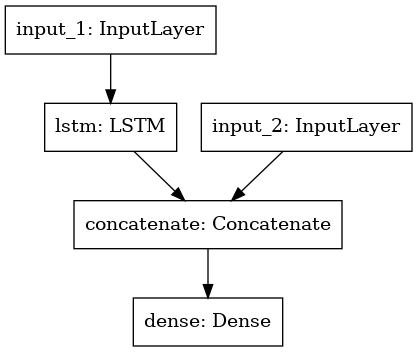

In [17]:
keras.utils.plot_model(modelVal.model)

In [18]:
# Training the model
history = modelVal.train()

Epoch 1/400
15/15 [==============================] - 0s 15ms/step - loss: 12.7166 - val_loss: 31.9123
Epoch 2/400
15/15 [==============================] - 0s 4ms/step - loss: 12.2899 - val_loss: 31.8704
Epoch 3/400
15/15 [==============================] - 0s 4ms/step - loss: 12.0125 - val_loss: 31.6544
Epoch 4/400
15/15 [==============================] - 0s 4ms/step - loss: 11.7632 - val_loss: 31.2837
Epoch 5/400
15/15 [==============================] - 0s 4ms/step - loss: 11.5238 - val_loss: 30.8056
Epoch 6/400
15/15 [==============================] - 0s 4ms/step - loss: 11.2913 - val_loss: 30.2808
Epoch 7/400
15/15 [==============================] - 0s 4ms/step - loss: 11.0626 - val_loss: 29.7287
Epoch 8/400
15/15 [==============================] - 0s 4ms/step - loss: 10.8410 - val_loss: 29.1854
Epoch 9/400
15/15 [==============================] - 0s 4ms/step - loss: 10.6360 - val_loss: 28.6654
Epoch 10/400
15/15 [==============================] - 0s 4ms/step - loss: 10.4451 - val_lo

15/15 [==============================] - 0s 4ms/step - loss: 6.2018 - val_loss: 11.6686
Epoch 83/400
15/15 [==============================] - 0s 4ms/step - loss: 6.1834 - val_loss: 11.5530
Epoch 84/400
15/15 [==============================] - 0s 5ms/step - loss: 6.1572 - val_loss: 11.4395
Epoch 85/400
15/15 [==============================] - 0s 4ms/step - loss: 6.1365 - val_loss: 11.3287
Epoch 86/400
15/15 [==============================] - 0s 4ms/step - loss: 6.1149 - val_loss: 11.2196
Epoch 87/400
15/15 [==============================] - 0s 4ms/step - loss: 6.0890 - val_loss: 11.1191
Epoch 88/400
15/15 [==============================] - 0s 4ms/step - loss: 6.0705 - val_loss: 11.0192
Epoch 89/400
15/15 [==============================] - 0s 4ms/step - loss: 6.0454 - val_loss: 10.9185
Epoch 90/400
15/15 [==============================] - 0s 4ms/step - loss: 6.0283 - val_loss: 10.8220
Epoch 91/400
15/15 [==============================] - 0s 4ms/step - loss: 6.0049 - val_loss: 10.7293
Epo

15/15 [==============================] - 0s 4ms/step - loss: 3.8813 - val_loss: 2.9041
Epoch 245/400
15/15 [==============================] - 0s 4ms/step - loss: 3.8554 - val_loss: 2.7867
Epoch 246/400
15/15 [==============================] - 0s 4ms/step - loss: 3.8425 - val_loss: 2.6701
Epoch 247/400
15/15 [==============================] - 0s 4ms/step - loss: 3.8376 - val_loss: 2.5493
Epoch 248/400
15/15 [==============================] - 0s 4ms/step - loss: 3.8129 - val_loss: 2.4260
Epoch 249/400
15/15 [==============================] - 0s 4ms/step - loss: 3.7998 - val_loss: 2.3058
Epoch 250/400
15/15 [==============================] - 0s 4ms/step - loss: 3.8003 - val_loss: 2.1877
Epoch 251/400
15/15 [==============================] - 0s 4ms/step - loss: 3.7726 - val_loss: 2.0680
Epoch 252/400
15/15 [==============================] - 0s 4ms/step - loss: 3.7598 - val_loss: 1.9504
Epoch 253/400
15/15 [==============================] - 0s 4ms/step - loss: 3.7615 - val_loss: 1.8311
Epoc

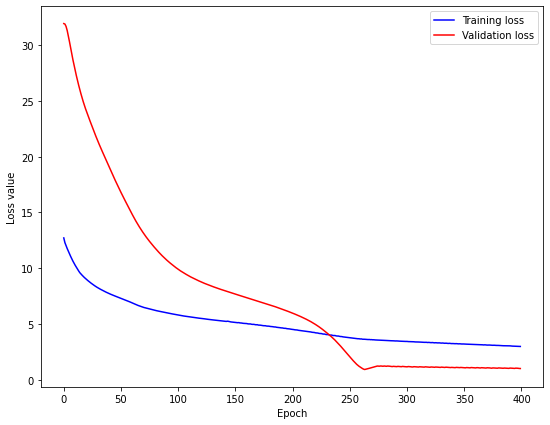

In [19]:
mse = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [20]:
yhatval_abs = [np.exp(x[0]) for x in modelVal.predict([Xval, Xauxval])]
yval_abs = [np.exp(x) for x in Yval]

#yhatval_abs = [x[0] for x in modelVal.predict([Xval, Xauxval])]
#yval_abs = [x for x in Yval]


fc = pd.concat([
    pd.DataFrame({'value': yval_abs, 'index': range(n_val), 'type': 'original'}),
    pd.DataFrame({'value': yhatval_abs, 'index': range(n_val), 'type': 'forecast'})
], axis=0)

<AxesSubplot:xlabel='index', ylabel='value'>

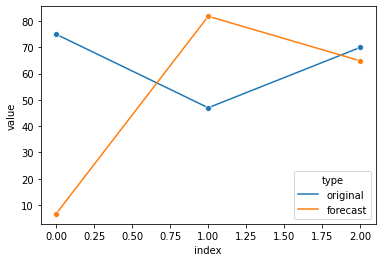

In [21]:
sns.lineplot(x='index', y='value', data=fc, hue='type', marker='o')

In [22]:
# Initiating the model
modelFinal = NNmodelAux(
    X=X, 
    Xaux=Xaux,
    Y=Y, 
    n_lag=n_lag, 
    n_ft=n_ft
)

# Training the model 
history = modelFinal.train()

Epoch 1/400
15/15 [==============================] - 0s 4ms/step - loss: 13.6251
Epoch 2/400
15/15 [==============================] - 0s 3ms/step - loss: 13.4158
Epoch 3/400
15/15 [==============================] - 0s 3ms/step - loss: 13.2315
Epoch 4/400
15/15 [==============================] - 0s 3ms/step - loss: 13.0517
Epoch 5/400
15/15 [==============================] - 0s 3ms/step - loss: 12.8767
Epoch 6/400
15/15 [==============================] - 0s 4ms/step - loss: 12.7071
Epoch 7/400
15/15 [==============================] - 0s 3ms/step - loss: 12.5408
Epoch 8/400
15/15 [==============================] - 0s 4ms/step - loss: 12.3808
Epoch 9/400
15/15 [==============================] - 0s 5ms/step - loss: 12.2246
Epoch 10/400
15/15 [==============================] - 0s 4ms/step - loss: 12.0704
Epoch 11/400
15/15 [==============================] - 0s 6ms/step - loss: 11.9175
Epoch 12/400
15/15 [==============================] - 0s 5ms/step - loss: 11.7670
Epoch 13/400
15/15 [=====

15/15 [==============================] - 0s 3ms/step - loss: 3.3308
Epoch 202/400
15/15 [==============================] - 0s 3ms/step - loss: 3.3251
Epoch 203/400
15/15 [==============================] - 0s 3ms/step - loss: 3.3194
Epoch 204/400
15/15 [==============================] - 0s 3ms/step - loss: 3.3135
Epoch 205/400
15/15 [==============================] - 0s 3ms/step - loss: 3.3076
Epoch 206/400
15/15 [==============================] - 0s 3ms/step - loss: 3.3039
Epoch 207/400
15/15 [==============================] - 0s 3ms/step - loss: 3.2990
Epoch 208/400
15/15 [==============================] - 0s 3ms/step - loss: 3.2932
Epoch 209/400
15/15 [==============================] - 0s 3ms/step - loss: 3.2873
Epoch 210/400
15/15 [==============================] - 0s 3ms/step - loss: 3.2814
Epoch 211/400
15/15 [==============================] - 0s 3ms/step - loss: 3.2752
Epoch 212/400
15/15 [==============================] - 0s 3ms/step - loss: 3.2719
Epoch 213/400
15/15 [=========

15/15 [==============================] - 0s 3ms/step - loss: 2.8190
Epoch 302/400
15/15 [==============================] - 0s 3ms/step - loss: 2.8139
Epoch 303/400
15/15 [==============================] - 0s 3ms/step - loss: 2.8101
Epoch 304/400
15/15 [==============================] - 0s 3ms/step - loss: 2.8055
Epoch 305/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7943
Epoch 306/400
15/15 [==============================] - 0s 4ms/step - loss: 2.7876
Epoch 307/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7847
Epoch 308/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7750
Epoch 309/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7738
Epoch 310/400
15/15 [==============================] - 0s 4ms/step - loss: 2.7725
Epoch 311/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7652
Epoch 312/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7597
Epoch 313/400
15/15 [=========

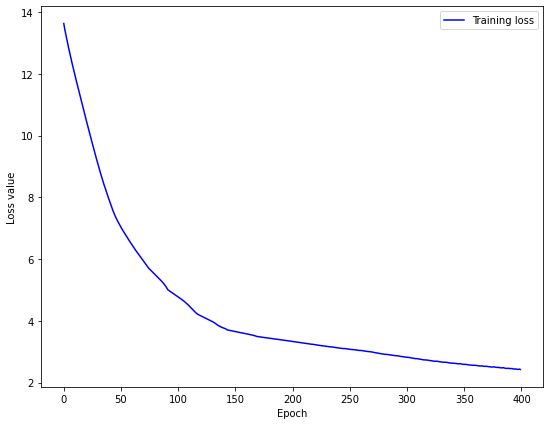

In [23]:
mse = history.history.get('loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [24]:
# Getting the newest data 
Ynew = Yts[-n_lag:]

# Reshaping for the model input 
Ynew = np.reshape(Ynew, (1, n_lag, n_ft))

print(f'Shape of the input for prediction: {Ynew.shape}')

Shape of the input for prediction: (1, 21, 13)


In [25]:
# Creating the dummy variable data 

# Getting the last date in the dataset 
next_day = d.tail(1)['day'].values[0] + datetime.timedelta(1)

# Getting the day of week indicator; +1 because the default monday is 0
dayofweek = next_day.weekday() + 1

weekdayframe = pd.DataFrame({
    'weekday_1': 0, 
    'weekday_2': 0,
    'weekday_3': 0,
    'weekday_4': 0,
    'weekday_5': 0,
    'weekday_6': 0,
    'weekday_7': 0,
    'is_quarantine': 1
}, index=[0])

weekdayframe[f"weekday_{dayofweek}"] = 1

weekdayframe = weekdayframe.values

In [26]:
yhat = modelFinal.predict([Ynew, weekdayframe])[0]
print(f'Prediction: {np.exp(yhat[0])}')

Prediction: 99.73789978027344


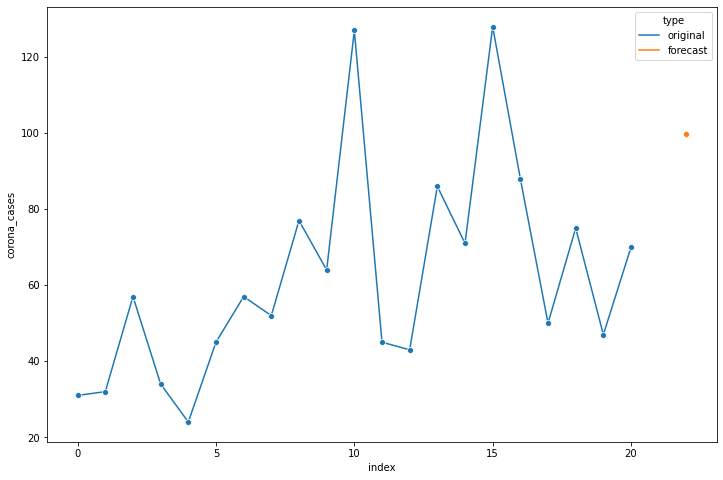

In [27]:
# Visualizing the prediction 
dorig = pd.DataFrame({
    'index': range(n_lag), 'corona_cases': [np.exp(x) for x in Y[-n_lag:]],
    'type': 'original'
})
dfc = pd.DataFrame({'index': n_lag + 1, 'corona_cases': np.exp(yhat[0]), 'type': 'forecast'}, index=[0])

dplot = pd.concat([dorig, dfc], axis=0)
plt.figure(figsize=(12, 8))
sns.lineplot(x='index', y='corona_cases', data=dplot, hue='type', marker='o')
plt.show()

In [28]:
# Simulating a 14 day window 
last_14_days = d.tail(14)['day'].values

predictions = []

for day in last_14_days:
    dd = d[d['day']<day]
    
    Yts = dd.drop([
        'day', 
        'weekday_1', 
        'weekday_2',
        'weekday_3',
        'weekday_4',
        'weekday_5',
        'weekday_6',
        'weekday_7',
        'is_quarantine'
    ], axis=1)

    # Adding a very small value 
    eps = 0.0000001
    Yts = Yts.apply(lambda x: x + eps)

    # Getting the logs 
    Yts = Yts.apply(np.log)

    Yts = Yts.values

    Xaux = dd[
        [
            'weekday_1', 
            'weekday_2',
            'weekday_3',
            'weekday_4',
            'weekday_5',
            'weekday_6',
            'weekday_7',
            'is_quarantine'
        ]
    ].values

    # Defining the lag 
    n_lag = 14

    # Number of features used in modeling
    n_ft = Yts.shape[1]

    # Creating the X and Y input for the LSTM model 
    X, Y = create_X_Y_generalized(Yts, n_features=n_ft, lag=n_lag)

    # Removing the first n_lag rows from auxilary data 
    Xaux = Xaux[:-n_lag]

    model = NNmodelAux(
        X=X, 
        Xaux=Xaux,
        Y=Y, 
        n_ft=n_ft,
        n_lag=n_lag
    )

    model.train()

    # Getting the newest data 
    Ynew = Yts[-n_lag:]

    # Reshaping for the model input 
    Ynew = np.reshape(Ynew, (1, n_lag, n_ft))

    # Getting the last date in the dataset 
    next_day = dd.tail(1)['day'].values[0] + datetime.timedelta(1)

    # Getting the day of week indicator; +1 because the default monday is 0
    dayofweek = next_day.weekday() + 1

    weekdayframe = pd.DataFrame({
        'weekday_1': 0, 
        'weekday_2': 0,
        'weekday_3': 0,
        'weekday_4': 0,
        'weekday_5': 0,
        'weekday_6': 0,
        'weekday_7': 0,
        'is_quarantine': 1
    }, index=[0])

    weekdayframe[f"weekday_{dayofweek}"] = 1

    weekdayframe = weekdayframe.values
    
    yhat = model.predict([Ynew, weekdayframe])[0][0]
    yhat_abs = np.exp(yhat)

    predictions.append(yhat_abs)

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 17.2904
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 16.9742
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 16.6843
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 16.3947
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 16.1085
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 15.8270
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 15.5503
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 15.2816
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 15.0218
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 14.7716
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 14.5273
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 14.2896
Epoch 13/400
15/15 [=====

15/15 [==============================] - 0s 2ms/step - loss: 3.7601
Epoch 202/400
15/15 [==============================] - 0s 2ms/step - loss: 3.7518
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 3.7433
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.7351
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.7264
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.7182
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.7100
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.7018
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.6936
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.6858
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.6784
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.6711
Epoch 213/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 3.2049
Epoch 302/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1994
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1963
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1909
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1865
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1846
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1787
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1742
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1693
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1648
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1633
Epoch 312/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1574
Epoch 313/400
15/15 [=========

15/15 [==============================] - 0s 3ms/step - loss: 13.1303
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 12.9633
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 12.8115
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 12.6624
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 12.5148
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 12.3690
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 12.2259
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 12.0868
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 11.9498
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 11.8142
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 11.6796
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 11.5458
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 5.3070
Epoch 103/400
15/15 [==============================] - 0s 2ms/step - loss: 5.2902
Epoch 104/400
15/15 [==============================] - 0s 3ms/step - loss: 5.2731
Epoch 105/400
15/15 [==============================] - 0s 2ms/step - loss: 5.2559
Epoch 106/400
15/15 [==============================] - 0s 2ms/step - loss: 5.2386
Epoch 107/400
15/15 [==============================] - 0s 2ms/step - loss: 5.2211
Epoch 108/400
15/15 [==============================] - 0s 2ms/step - loss: 5.2037
Epoch 109/400
15/15 [==============================] - 0s 2ms/step - loss: 5.1868
Epoch 110/400
15/15 [==============================] - 0s 3ms/step - loss: 5.1694
Epoch 111/400
15/15 [==============================] - 0s 2ms/step - loss: 5.1521
Epoch 112/400
15/15 [==============================] - 0s 2ms/step - loss: 5.1357
Epoch 113/400
15/15 [==============================] - 0s 2ms/step - loss: 5.1195
Epoch 114/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 3.9528
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9462
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9402
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9336
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9280
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9216
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9157
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9096
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9041
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.8979
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.8914
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 3.8852
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 3ms/step - loss: 3.1755
Epoch 303/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1684
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1595
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 3.1519
Epoch 306/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1452
Epoch 307/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1393
Epoch 308/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1328
Epoch 309/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1286
Epoch 310/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1231
Epoch 311/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1158
Epoch 312/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1095
Epoch 313/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1028
Epoch 314/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 9.0413
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 8.9276
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 8.8046
Epoch 5/400
15/15 [==============================] - 0s 3ms/step - loss: 8.6675
Epoch 6/400
15/15 [==============================] - 0s 3ms/step - loss: 8.5662
Epoch 7/400
15/15 [==============================] - 0s 3ms/step - loss: 8.4817
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 8.4024
Epoch 9/400
15/15 [==============================] - 0s 3ms/step - loss: 8.3245
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 8.2443
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 8.1541
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 8.0507
Epoch 13/400
15/15 [==============================] - 0s 2ms/step - loss: 7.9783
Epoch 14/400
15/15 [============================

15/15 [==============================] - 0s 3ms/step - loss: 3.5008
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4970
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4885
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4719
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4637
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4607
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4515
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4643
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4498
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4388
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4315
Epoch 214/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4345
Epoch 215/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 2.9455
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9322
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9303
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9168
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9171
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9101
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9162
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8954
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9015
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8979
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8976
Epoch 314/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9287
Epoch 315/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 4.4402
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 4.4173
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 4.3975
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 4.3785
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 4.3606
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 4.3436
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 4.3273
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 4.3118
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 4.2966
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 4.2813
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 4.2660
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 4.2509
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 2.9249
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9201
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9155
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9111
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9063
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9018
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8970
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8923
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8875
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8828
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8779
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8732
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 3ms/step - loss: 2.5041
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 2.5006
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4985
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4941
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4923
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4881
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4849
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4812
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4786
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4758
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4727
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.4692
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 6.5736
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 6.4877
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 6.4047
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 6.3234
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 6.2463
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 6.1747
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 6.1080
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 6.0502
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 5.9951
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 5.9421
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 5.8910
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 5.8414
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 2.8280
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8227
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8096
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8122
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 2.7980
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 2.7994
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 2.7830
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 2.7889
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 2.7758
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 2.7746
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 2.7599
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 2.7627
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 2.3695
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3576
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3570
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3506
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3516
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3511
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3514
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3383
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3430
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3416
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3329
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.3339
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 7.5777
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 7.5231
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 7.4716
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 7.4208
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 7.3714
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 7.3228
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 7.2749
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 7.2281
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 7.1814
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 7.1363
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 7.0947
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 7.0549
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 3.9730
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9682
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9624
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9577
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9527
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9472
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9418
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9367
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9324
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9270
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9226
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 3.9171
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 3.5116
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 3.5074
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 3.5027
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4983
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4941
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4898
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4854
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4807
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4765
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4722
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4679
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4647
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 8.6350
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 8.5696
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 8.5074
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 8.4466
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 8.3890
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 8.3326
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 8.2771
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 8.2227
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 8.1692
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 8.1164
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 8.0644
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 8.0134
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 3.4934
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4876
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4819
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4759
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4699
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4648
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4588
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4537
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4481
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4427
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4373
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4320
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 3.0097
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0051
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0007
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9962
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9916
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9873
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9830
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9781
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9735
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9697
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9651
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9605
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 10.3506
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 10.1967
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 10.0564
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 9.9204
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 9.7872
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 9.6568
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 9.5298
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 9.4067
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 9.2867
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 9.1695
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 9.0546
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 8.9420
Epoch 13/400
15/15 [==============

15/15 [==============================] - 0s 2ms/step - loss: 3.0866
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0806
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0750
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0695
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0638
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0584
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0529
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0477
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0425
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0375
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0319
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0265
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 2.6439
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6399
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6355
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6318
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6289
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6241
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6207
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6165
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6132
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6088
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6043
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6017
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 5.6018
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 5.5669
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 5.5373
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 5.5087
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 5.4802
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 5.4516
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 5.4239
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 5.3964
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 5.3692
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 5.3422
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 5.3154
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 5.2889
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 3.4299
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4257
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4214
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4173
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4132
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4091
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4050
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4010
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.3969
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.3929
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.3889
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 3.3849
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 3.0867
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0837
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0806
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0776
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0747
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0714
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0684
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0652
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0622
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0591
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0558
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 3.0527
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 5.0206
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9915
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9649
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9390
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9137
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 4.8888
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 4.8642
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 4.8397
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 4.8155
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 4.7922
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 4.7698
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 4.7474
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 2.9947
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9912
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9873
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9836
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9810
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9766
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9736
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9697
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9656
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9621
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9585
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 2.9549
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 2.6569
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6544
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6509
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6484
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6445
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6408
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6383
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6359
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6319
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6279
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6251
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6209
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 6.4126
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 6.3659
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 6.3259
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 6.2870
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 6.2494
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 6.2134
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 6.1780
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 6.1431
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 6.1087
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 6.0750
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 6.0418
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 6.0094
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 3.4696
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4602
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4532
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4456
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4417
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4356
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4262
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4193
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4144
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.4056
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.3972
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 3.3904
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 2.8866
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8853
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8724
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8676
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8655
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8586
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8566
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8544
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8629
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8459
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8493
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8441
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 5.1355
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 5.1128
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 5.0924
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 5.0719
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 5.0509
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 5.0309
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 5.0113
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9916
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9716
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9510
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9284
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 4.9044
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 3.2848
Epoch 203/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2794
Epoch 204/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2756
Epoch 205/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2726
Epoch 206/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2653
Epoch 207/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2620
Epoch 208/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2556
Epoch 209/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2522
Epoch 210/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2457
Epoch 211/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2411
Epoch 212/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2383
Epoch 213/400
15/15 [==============================] - 0s 2ms/step - loss: 3.2320
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 2.8523
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8444
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8451
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8379
Epoch 306/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8334
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8291
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8259
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8244
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8188
Epoch 311/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8163
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8122
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.8081
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 6.5418
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 6.4816
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 6.4258
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 6.3709
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 6.3165
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 6.2622
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 6.2095
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 6.1573
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 6.1104
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 6.0647
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 6.0203
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 5.9744
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 3ms/step - loss: 3.1627
Epoch 203/400
15/15 [==============================] - 0s 4ms/step - loss: 3.1566
Epoch 204/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1525
Epoch 205/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1465
Epoch 206/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1407
Epoch 207/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1357
Epoch 208/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1300
Epoch 209/400
15/15 [==============================] - 0s 4ms/step - loss: 3.1242
Epoch 210/400
15/15 [==============================] - 0s 4ms/step - loss: 3.1197
Epoch 211/400
15/15 [==============================] - 0s 4ms/step - loss: 3.1144
Epoch 212/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1080
Epoch 213/400
15/15 [==============================] - 0s 3ms/step - loss: 3.1041
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 2.7003
Epoch 303/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6970
Epoch 304/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6934
Epoch 305/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6890
Epoch 306/400
15/15 [==============================] - 0s 3ms/step - loss: 2.6864
Epoch 307/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6821
Epoch 308/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6788
Epoch 309/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6749
Epoch 310/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6711
Epoch 311/400
15/15 [==============================] - 0s 3ms/step - loss: 2.6684
Epoch 312/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6646
Epoch 313/400
15/15 [==============================] - 0s 2ms/step - loss: 2.6608
Epoch 314/400
15/15 [=========

Epoch 1/400
15/15 [==============================] - 0s 3ms/step - loss: 5.8712
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 5.8129
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 5.7623
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 5.7140
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 5.6672
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 5.6224
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 5.5794
Epoch 8/400
15/15 [==============================] - 0s 2ms/step - loss: 5.5373
Epoch 9/400
15/15 [==============================] - 0s 2ms/step - loss: 5.4961
Epoch 10/400
15/15 [==============================] - 0s 2ms/step - loss: 5.4558
Epoch 11/400
15/15 [==============================] - 0s 2ms/step - loss: 5.4163
Epoch 12/400
15/15 [==============================] - 0s 2ms/step - loss: 5.3781
Epoch 13/400
15/15 [=================

15/15 [==============================] - 0s 4ms/step - loss: 2.7653
Epoch 203/400
15/15 [==============================] - 0s 4ms/step - loss: 2.7608
Epoch 204/400
15/15 [==============================] - 0s 4ms/step - loss: 2.7563
Epoch 205/400
15/15 [==============================] - 0s 4ms/step - loss: 2.7524
Epoch 206/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7476
Epoch 207/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7435
Epoch 208/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7388
Epoch 209/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7350
Epoch 210/400
15/15 [==============================] - 0s 4ms/step - loss: 2.7313
Epoch 211/400
15/15 [==============================] - 0s 3ms/step - loss: 2.7270
Epoch 212/400
15/15 [==============================] - 0s 4ms/step - loss: 2.7229
Epoch 213/400
15/15 [==============================] - 0s 4ms/step - loss: 2.7175
Epoch 214/400
15/15 [=========

15/15 [==============================] - 0s 4ms/step - loss: 2.4232
Epoch 303/400
15/15 [==============================] - 0s 4ms/step - loss: 2.4205
Epoch 304/400
15/15 [==============================] - 0s 4ms/step - loss: 2.4173
Epoch 305/400
15/15 [==============================] - 0s 3ms/step - loss: 2.4139
Epoch 306/400
15/15 [==============================] - 0s 3ms/step - loss: 2.4127
Epoch 307/400
15/15 [==============================] - 0s 3ms/step - loss: 2.4137
Epoch 308/400
15/15 [==============================] - 0s 3ms/step - loss: 2.4093
Epoch 309/400
15/15 [==============================] - 0s 3ms/step - loss: 2.4070
Epoch 310/400
15/15 [==============================] - 0s 4ms/step - loss: 2.4033
Epoch 311/400
15/15 [==============================] - 0s 3ms/step - loss: 2.4017
Epoch 312/400
15/15 [==============================] - 0s 4ms/step - loss: 2.4013
Epoch 313/400
15/15 [==============================] - 0s 3ms/step - loss: 2.3974
Epoch 314/400
15/15 [=========

In [29]:
dpred = d[d['day'].isin(last_14_days)].copy() 
dpred['yhat'] = predictions

In [30]:
dpred

,day,is_hospitalized,is_covid-0-9,is_covid-10-19,is_covid-100-109,is_covid-120-129,is_covid-20-29,is_covid-30-39,is_covid-40-49,is_covid-50-59,...,is_covid-90-99,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,is_quarantine,yhat
239,2020-11-04,52,40.0,41.0,0.0,0.0,158.0,177.0,160.0,201.0,...,9.0,0,0,1,0,0,0,0,1,13.875733
240,2020-11-05,77,56.0,50.0,0.0,0.0,256.0,302.0,322.0,311.0,...,17.0,0,0,0,1,0,0,0,1,221.466934
241,2020-11-06,64,51.0,87.0,1.0,0.0,296.0,316.0,375.0,383.0,...,14.0,0,0,0,0,1,0,0,1,83.921356
242,2020-11-07,127,45.0,69.0,0.0,1.0,315.0,337.0,334.0,403.0,...,14.0,0,0,0,0,0,1,0,1,134.923874
243,2020-11-08,45,34.0,55.0,0.0,0.0,185.0,173.0,156.0,182.0,...,5.0,0,0,0,0,0,0,1,1,108.362129
244,2020-11-09,43,23.0,50.0,0.0,0.0,165.0,161.0,216.0,200.0,...,7.0,1,0,0,0,0,0,0,1,22.539061
245,2020-11-10,86,60.0,64.0,1.0,0.0,209.0,223.0,260.0,276.0,...,6.0,0,1,0,0,0,0,0,1,24.405296
246,2020-11-11,71,32.0,70.0,0.0,0.0,237.0,267.0,264.0,329.0,...,12.0,0,0,1,0,0,0,0,1,128.505142
247,2020-11-12,128,42.0,113.0,1.0,0.0,284.0,306.0,360.0,430.0,...,21.0,0,0,0,1,0,0,0,1,91.340263
248,2020-11-13,88,44.0,70.0,0.0,0.0,195.0,244.0,296.0,314.0,...,18.0,0,0,0,0,1,0,0,1,37.730774


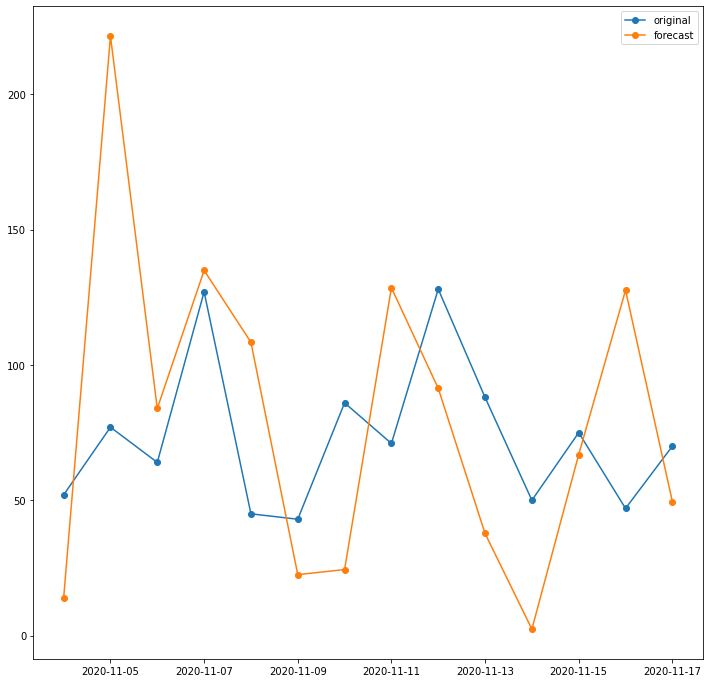

In [31]:
plt.figure(figsize=(12, 12))
plt.plot('day', 'is_hospitalized', '-o', data=dpred, label='original')
plt.plot('day', 'yhat', '-o', data=dpred, label='forecast')
plt.legend()
plt.show()